# Binary classification from 2 features using Tensor Flow 2.0


Based on the same data model as in the **Binary classification notebook** ([HTML](ClassificationContinuous2Features.html) / [Jupyter](ClassificationContinuous2Features.ipynb)).

The classification is on a single boundary defined by a continuous function and added white noise.

Learning goals:
- Learn about TensorFlow as a deep learning computation engine
    - Symbolic description of a pipeline (versus value based)
    - Understand the Tensors
    - Powerful gradient optimizers
    - The concepts of layers and metrics
    
This tutorial is an intermediate step between the home made binary regression, and the fully packaged regression implemented with the Keras API of TensorFlow in **Binary classification from 2 features with Keras** ([HTML](ClassificationContinuous2Features-Keras.html) / [Jupyter](ClassificationContinuous2Features-Keras.ipynb))

In [1]:
import tensorflow as tf # Requires TF v2.0+
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
import pandas
# Local file to fix some issue in the heat map of the confusion matrix
from heat_map import plot_heat_map

## Model

Quadratic function as a boundary between positive and negative values

Adding some unknown as a Gaussian noise

The values of X are uniformly distributed and independent

In [2]:
# Two features, Gaussian noise
nFeatures = 2
def generateBatch(N):
    #
    xMin = 0
    xMax = 1
    b = 0.1
    std = 0.1
    #
    x = random.uniform(xMin, xMax, (N, nFeatures))
    # 4th degree relation to shape the boundary
    boundary = 2*(x[:,0]**4 + (x[:,0]-0.3)**3 + b)
    # Adding some gaussian noise
    labels = boundary + random.normal(0, std, N) > x[:,1]
    return (x, labels)

### Training data

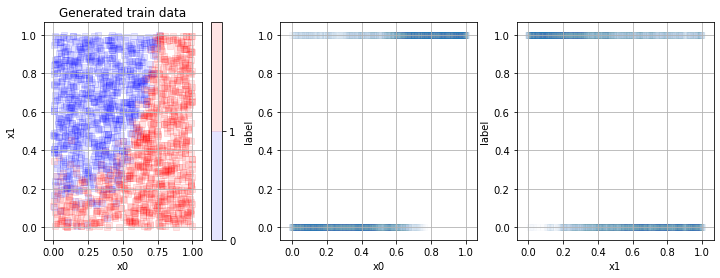

In [3]:
N = 2000
# x has 1 dim in R, label has 1 dim in B
xTrain, labelTrain = generateBatch(N)

colors = ['blue','red']

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTrain[:,0], xTrain[:,1], c=labelTrain, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Generated train data')
plt.grid()
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1])
plt.subplot(1,3,2)
plt.scatter(xTrain[:,0], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x0')
plt.ylabel('label')
plt.grid()
plt.subplot(1,3,3)
plt.scatter(xTrain[:,1], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x1')
plt.ylabel('label')
plt.grid()

Bernouilli parameter of the distribution: 0.5145


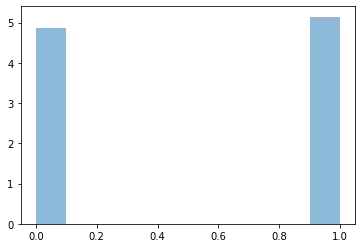

In [4]:
count, bins, ignored = plt.hist(labelTrain*1.0, 10, density=True, alpha=0.5)
p = np.mean(labelTrain)
print('Bernouilli parameter of the distribution:', p)

### Test data for verification of the model

In [5]:
xTest, labelTest = generateBatch(N)
testColors = ['navy', 'orangered']

# Using TensorFlow 2.0

In [6]:
# Labels as float {0., 1.}
labelTrainF = np.multiply(labelTrain*1.0, 1.0)
labelTrainF.dtype

dtype('float64')

In [7]:
# (Mini) Batch size
nBatch = 128
# Number of batches per Epoch
nBatchPerEpoch = 10
# Safe guard to stop on number of epochs
nEpochMax = 2000

In [8]:
# Simple custom layer exposing the logistic regression model
class MyLogisticRegressionLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(MyLogisticRegressionLayer, self).__init__(*args, **kwargs)
    
    def build(self, input_shape):
        print('Logistic layer input_shape', input_shape)
        self.w = self.add_weight(
            shape=[input_shape[1], 1],
            dtype=self.dtype,
            initializer=tf.keras.initializers.ones(),
            #regularizer=tf.keras.regularizers.l2(0.02),
            trainable=True)
        self.b = self.add_weight(
            shape=1,
            dtype=self.dtype,
            initializer=tf.keras.initializers.ones(),
            #regularizer=tf.keras.regularizers.l2(0.02),
            trainable=True)

    @tf.function
    def call(self, x, training=None):
        logits = tf.matmul(x, self.w) + self.b
        predictions = tf.math.sigmoid(logits)
        return predictions

**Accuracy** is defined as:
$$ \mathcal{Accuracy} = \frac 1n \sum_{i=1}^n \mathbb{1}_{\hat{y}_i = y_i}$$

With : 
- $\hat{y_i} \in \{0, 1\}$ the estimated label
- $y_i \in \{0, 1\}$ the actual label
- $\mathbb{1}$ the characteristic function wich is 1 when argument is true and 0 otherwise

In [9]:
# Using TensorFlow 2.0 style of metrics to implement accuracy
class MyBinaryAccuracy(tf.keras.metrics.Metric):

    def __init__(self, name='my_accuracy', **kwargs):
        super(MyBinaryAccuracy, self).__init__(name=name, **kwargs)
        self.accuracySum = self.add_weight(name='accuracySum', 
                                           initializer='zeros')
        self.accuracyCount = self.add_weight(name='accuracyCount', 
                                             initializer='zeros')

    def update_state(self, labels, yEst):
        labels = tf.cast(labels, tf.bool)
        labelEst = tf.greater(yEst, 0.5)

        values = tf.cast(tf.equal(labels, labelEst), self.dtype)
        self.accuracySum.assign_add(tf.reduce_sum(values))
        self.accuracyCount.assign_add(values.get_shape()[0])

    def result(self):
        return self.accuracySum / self.accuracyCount

The loss is computed as binary cross-entropy on the predictions:

As per the [binary classification](ClassificationContinuous2Features.html) notebook, the formula is :

$$\begin{align}
J{_\theta} & = - \sum_{i=0}^N{log \bigl(y_i * sig(w,b, x_i) + (1-y_i) * \left(1-sig(w,b, x_i)\right) \bigr)} 
\end{align}$$

With :
$$\begin{align}
sig(w,b, x_i) &= \frac{1}{1+e^{-(w x_i + b)}} \\
y_i &\in \{0, 1\}
\end{align}$$ 

In [10]:
# Model 1, instantiate the custom layer
model1 = tf.keras.Sequential([MyLogisticRegressionLayer(input_shape=[nFeatures], dtype=tf.float64)])

# Stochastic Gradient Descent Optimizer
optim1 = tf.keras.optimizers.SGD(0.01, momentum=0.01)

# Accuracy metric instance
accuracy = MyBinaryAccuracy()

# Perform a train step on a mini-batch
#  This function's code is rewritten by TensorFlow 2.0 and shall be compiled at every execution of the optimizer
@tf.function
def trainStep1(x, labels):
    with tf.GradientTape() as tape:
        predictions = model1(x, training=True)
        # Sigmoid cross-entropy from predictions
        loss = -tf.reduce_sum(tf.math.log((labels * predictions) + ((1 - labels) * (1 - predictions))))
        
    gradients = tape.gradient(loss, model1.trainable_variables)
    optim1.apply_gradients(zip(gradients, model1.trainable_variables))
    return loss, predictions
    
# Loop on epochs and mini batch
hist = []
for epoch in range(nEpochMax+1):
    cost_cumul = 0
    accuracy.reset_states()
    for b in range(0, nBatchPerEpoch):  
        (xTrain, labelTrain) = generateBatch(nBatch)
        labelTrainF = (labelTrain*1.0).reshape(-1, 1)
        cost, predictions = trainStep1(xTrain, labelTrainF)
        cost_cumul += cost
        accuracy.update_state(labelTrainF, predictions)
        
    cost_epoch = cost_cumul / nBatchPerEpoch
    W = model1.get_weights()
    hist.append((cost_epoch.numpy(), accuracy.result().numpy(), W[1][0], W[0][0][0], W[0][1][0]))
    # Displaying result on current Epoch 
    if (epoch) % 1000 == 0: 
        hNow = hist[-1]
        print("Epoch %4d, Cost: %.3f, Accuracy: %.3f, b: %.3f, W: %.3f, %.3f" \
               % (epoch, hNow[0], hNow[1], hNow[2], hNow[3], hNow[4]))

# Save history as a Panda Data Frame
df = pandas.DataFrame(hist, columns = ('cost', 'accuracy', 'b', 'w0', 'w1'))

Logistic layer input_shape (None, 2)
Epoch    0, Cost: 88.054, Accuracy: 0.676, b: -0.476, W: 1.321, -0.507
Epoch 1000, Cost: 30.125, Accuracy: 0.889, b: -1.149, W: 13.101, -10.336
Epoch 2000, Cost: 31.700, Accuracy: 0.882, b: -1.173, W: 13.254, -10.409


In [11]:
bEst = df['b'][len(df)-1]
wEst = np.array([df['w0'][len(df)-1], df['w1'][len(df)-1]]).reshape(-1)
print('Estimated b =', bEst, ', w =', wEst)

Estimated b = -1.1728504847198318 , w = [ 13.25404353 -10.40911633]


The accuracy is quickly reaching a good level!

But weights' convergence is very noisy showing numerical instability.

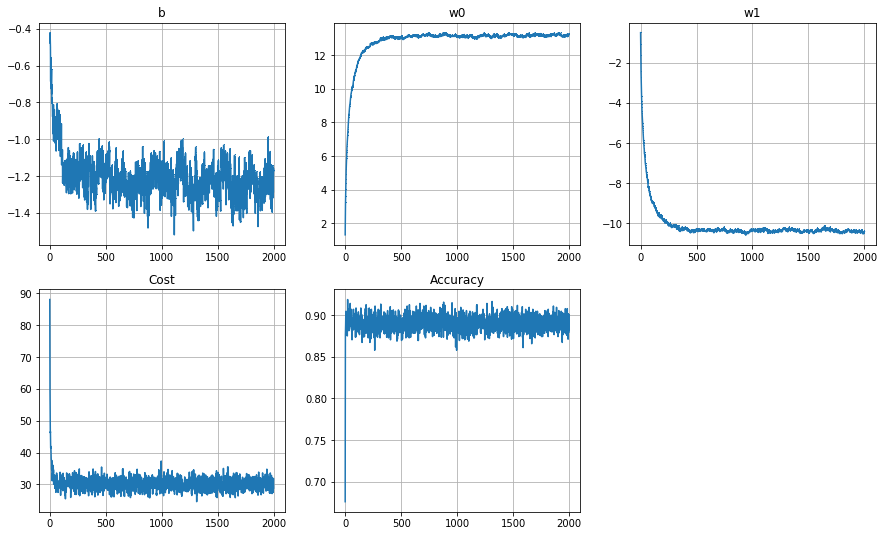

In [12]:
plt.figure(figsize=(15,9))
plt.subplot(2,3,1)
plt.plot(df['b'], marker=',');
plt.title('b')
plt.grid()
plt.subplot(2,3,2)
plt.plot(df['w0'], marker=',');
plt.title('w0')
plt.grid()
plt.subplot(2,3,3)
plt.plot(df['w1'], marker=',');
plt.title('w1')
plt.grid()
plt.subplot(2,3,4)
plt.plot(df['cost'])
plt.grid()
plt.title('Cost')
plt.subplot(2,3,5)
plt.plot(df['accuracy'])
plt.grid()
plt.title('Accuracy');

## Testing the model

In [13]:
yEst = model1(xTest).numpy()
labelEst = (yEst > 0.5).reshape(-1)

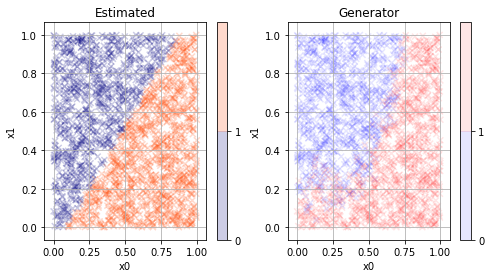

In [14]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], xTest[:,1], c=labelEst, cmap=pltcolors.ListedColormap(testColors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Estimated')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(testColors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);
plt.subplot(1,2,2)
plt.scatter(xTest[:,0], xTest[:,1], c=labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.1);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Generator')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);

Bernouilli parameter = 0.5465


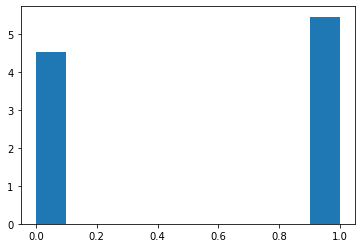

In [15]:
plt.hist(labelEst*1.0, 10, density=True)
print('Bernouilli parameter =', np.mean(labelEst))

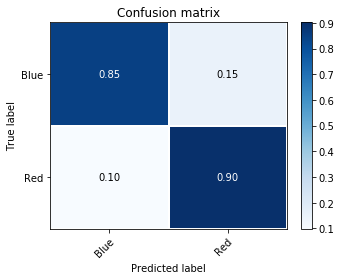

In [16]:
plot_heat_map(skMetrics.confusion_matrix(labelTest, labelEst), np.array(['Blue', 'Red']), normalize=True);

In [17]:
print(skMetrics.classification_report(labelTest, labelEst))

              precision    recall  f1-score   support

       False       0.89      0.85      0.87       945
        True       0.87      0.90      0.89      1055

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



# Conclusion

As we can reads in this turorial, designing a simple machine learning pipeline starting from math functions requires a lot of learning and details. Much time is spent digging into the details of the Tensors to fix dimensions.

Fortunatly, TensorFlow is also providing a higher level API, **Keras**. Same problem is solved in the **Binary classification from 2 features with Keras** ([HTML](ClassificationContinuous2Features-Keras.html) / [Jupyter](ClassificationContinuous2Features-Keras.ipynb)). 

# Where to go from here ?

__Other linear implementations and simple neural nets__ [using "raw" Python or SciKit Learn](ClassificationContinuous2Features.html) ([Notebook](ClassificationContinuous2Features.ipynb)), [using Keras](ClassificationContinuous2Features-Keras.html) ([Notebook](ClassificationContinuous2Features-Keras.ipynb)) up to a simple neural net to achieve better fit, or the [__K Nearest Neighbors classifier__](ClassificationContinuous2Features-KNN.html) ([Notebook](ClassificationContinuous2Features-KNN.ipynb))

__More complex multi-class models__ on the Czech and Norways flags [using Keras](ClassificationMulti2Features-Keras.html) ([Notebook](ClassificationMulti2Features-Keras.ipynb)), showing one of the main motivations to neural networks.

__Compare with the two feature linear regression__ [using simple algorithms](../linear/LinearRegressionBivariate.html) ([Notebook](LinearRegressionBivariate.ipynb])), [or using Keras](LinearRegressionBivariate-Keras.html) ([Notebook](LinearRegressionUnivariate-Keras.ipynb))